En este notebook vamos a hacer un pequeño ejercicio en el que **conectaremos Hadoop con ElasticSearch**. En concrecto, **haremos una conexión entre Hive y un índice (o index) de ElasticSearch**

Conectar Hadoop y ElasticSearch, puede ser beneficioso en varios escenarios. Por ejemplo:



*   **Análisis de Datos en Tiempo Real**: Elasticsearch permite realizar búsquedas y análisis de texto completo de manera eficiente. Al conectar Hadoop o Hive con Elasticsearch, se pueden analizar datos en tiempo real y obtener resultados rápidos en consultas complejas sobre grandes volúmenes de datos indexados en Elasticsearch.
*   **Integración de Fuentes de Datos**: Hadoop se utiliza comúnmente para procesar y almacenar grandes volúmenes de datos estructurados y no estructurados. Conectarlo con Elasticsearch nos permitirá integrar datos almacenados en Hadoop con Elasticsearch para facilitar el acceso y la búsqueda rápida de información.

*   **Indexación de Datos**: Podemos usar Hadoop para preparar y procesar datos antes de indexarlos en Elasticsearch. Esto es útil cuando debemos aplicar transformaciones complejas o agregaciones masivas antes de almacenar datos para análisis y búsqueda.

*   **Consultas y Visualizaciones Avanzadas**: Elasticsearch proporciona capacidades avanzadas para consultas y visualizaciones de datos. Al conectarlo con Hadoop o Hive, podemos ejecutar consultas complejas sobre grandes conjuntos de datos y obtener resultados rápidos y precisos, lo cual es útil para análisis de negocios, monitoreo en tiempo real, etc.
*   **Búsqueda y Recuperación de Información**: Utilizar Hadoop para procesar y preparar datos que luego se indexan en Elasticsearch, puede mejorar significativamente la capacidad de búsqueda y recuperación de información, permitiendo a los usuarios finales encontrar rápidamente la información relevante que necesitan.



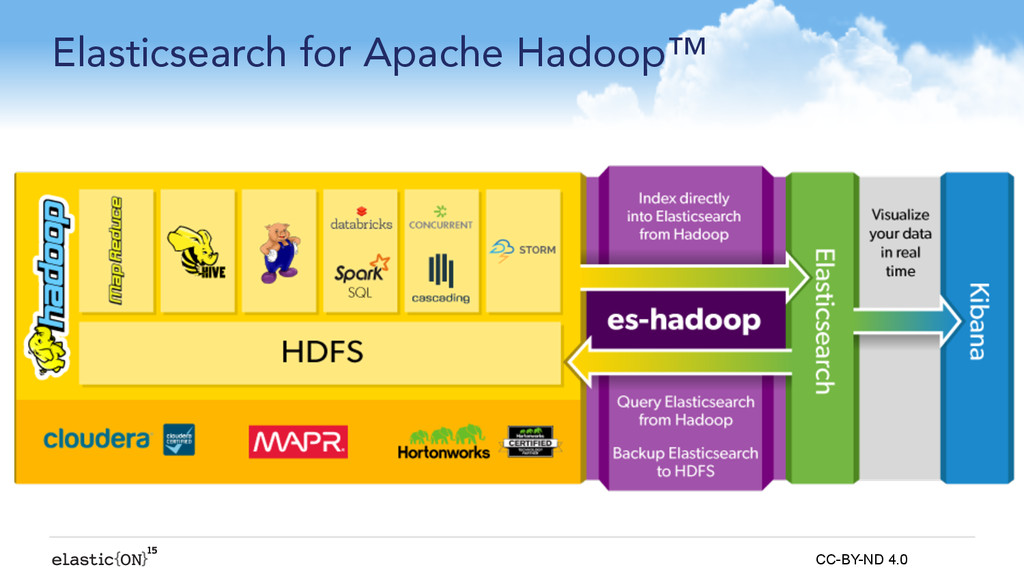

Si a esto le agregamos además la visualización con **Kibana**, obtenemos una potencia tremenda para la obtención, procesado y gestión completa de **Big Data**.

----------------------------------------------
# **INSTRUCCIONES DE ENTREGA**

Cada uno de los apartados de la práctica tiene un entregable, que en todos los casos es una captura de pantalla del resultado del proceso llevado a cabo en la parte (se indica cómo debe ser al final de cada apartado).

Estas capturas de pantalla deben ser colocadas en un archivo de texto (word, excel) que será convertido finalmente a pdf para su entrega.

El producto entregable será un único documento en formato pdf conteniendo las capturas de las diferentes partes de la práctica.

-----------------------------

# PARTE 1 - Configuración ES-Hadoop

Para configurar nuestro **ES-Hadoop**, vamos a necesitar herramientas que ya hemos utilizado a lo largo del módulo.



*   Un cluster standalone o standard en Dataproc
*   Un ELK (Elastic Search, Logstash, Kibana) de Elasticsearch

(Logstash es una herramienta de procesamiento de datos que permite la ingestión desde múltiples fuentes en Elasticsearch. Puede parsear, enriquecer y transformar los datos antes de enviarlos a ES para su almacenamiento y análisis)

También tendremos que hacer algunos cambios en la configuración previamente, como instalar librerías de soporte en Hadoop y poner elasticsearch en modo inseguro para esta prueba.

### a) Creamos un cluster Hadoop

### b) Cargamos en el cluster los jars de configuración de elasticsearch-hadoop y commons-httpclient

- Descarguemos estos jars:

    -     https://artifacts.elastic.co/downloads/elasticsearch-hadoop/elasticsearch-hadoop-8.14.1.zip
    -     https://repo1.maven.org/maven2/commons-httpclient/commons-httpclient/3.1/commons-httpclient-3.1.jar

- Creamos un nuevo bucket para nuestro ES-Hadoop

- Extraemos el contenido del zip, y **subimos ambos jar a nuestro bucket** en google storage
  
  **OJO** 👀 Subamos al bucket el archivo **elasticsearch-hadoop-8.14.1.jar** del zip, que se encuentra dentro de la carpeta **dist** del zip de elasticsearch-hadoop, no toda la carpeta. Podemos colocarlos en la ruta como se muestra en la siguiente imagen:

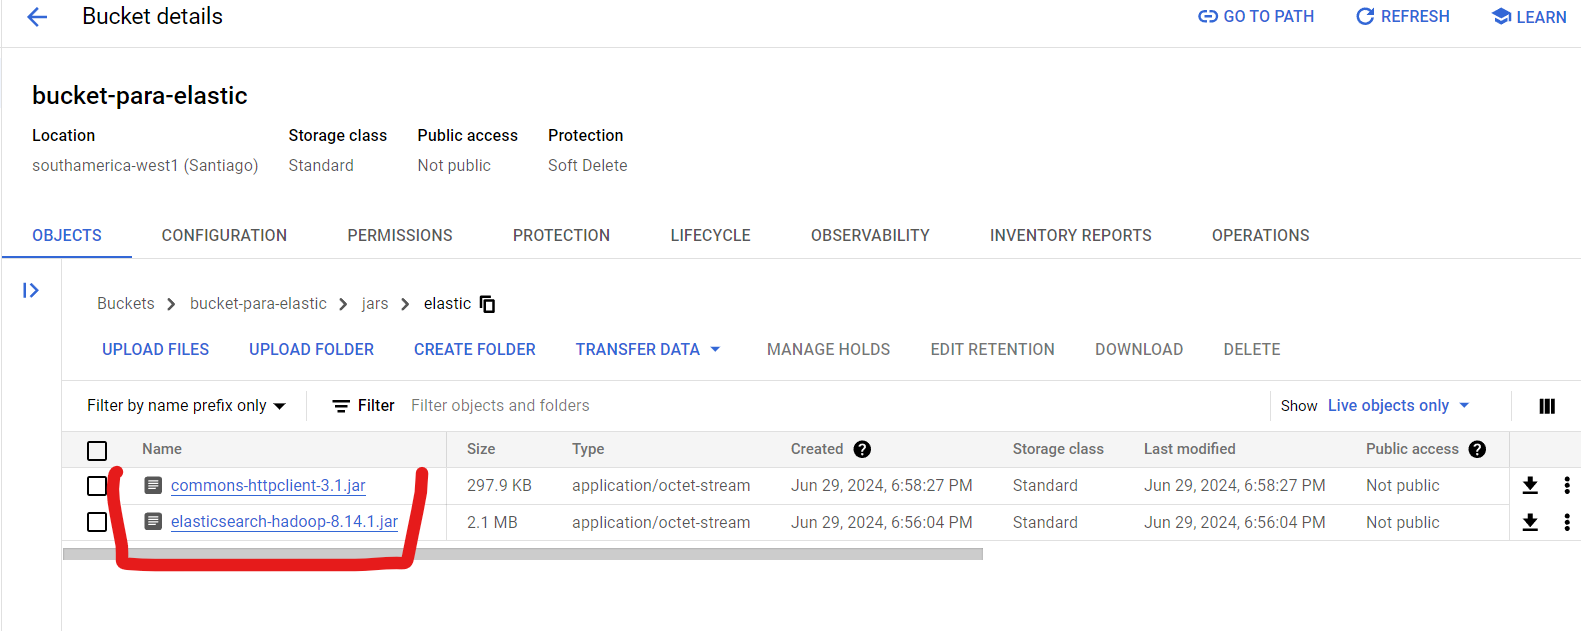

### c) Descargamos los jar desde el bucket al filesystem del cluster

Para eso tenemos que abrir la consola del nodo maestro del cluster y subirlos con los siguientes comandos:

```
gsutil cp gs://elastic-hadoop-1/elasticsearch-hadoop-8.14.1.jar .

gsutil cp gs://elastic-hadoop-1/commons-httpclient-3.1.jar .
```

Con el nombre de vuestro bucket, claro.


##**ENTREGABLE PARTE 1**: Captura de pantalla de la consola SSH del cluster Hadoop una vez finalizada la configuración y carga.

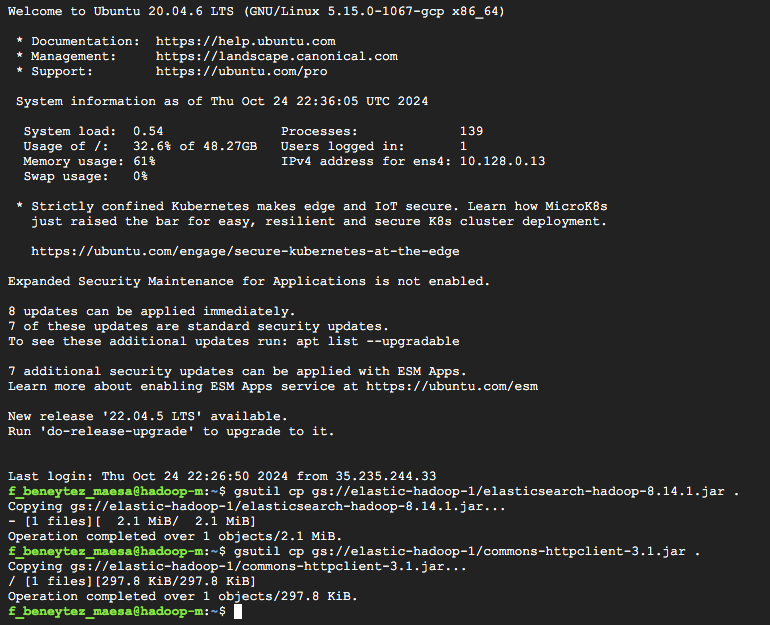

1. Tuve que cambiar la ruta de acceso propuesta por una propia omitiendo las carpetas jars y elastic ya que no las creé en el bucket.

# PARTE 2 - Configuración server Elasticsearch


- Creamos una nueva VM para elastic

- Configuramos la instancia de Elasticsearch



¿Qué más necesitaremos? 🤔

- Crear las reglas de firewall! -> Hay que abrir el puerto 9200 de elastic y permitir acceso desde la IP de la máquina master del cluster Hadoop.

También tenemos que abrir el puerto de Kibana (5601) para después. Deben estar abiertas para acceder desde el cluster Hadoop y también desde nuestro equipo local para que después podamos trabajar con Kibana.

**En resumen, los puertos 9200 y 5601 deben estar abiertos para nuestro equipo local y para el cluster Hadoop.**

Una vez tengamos todo esto, hagamos una comprobación para asegurar que el cluster Hadoop con Hive tiene acceso al server de Elastic. Para ello, desde la máquina del cluster Hadoop:

```
curl -I http://35.184.52.144:9200
```
(Con la IP de nuestro Elastic)

##**ENTREGABLE PARTE 2**: Captura de pantalla de la consola del server Elastic donde se vea la configuración de elastic, desde 'Enable security features' hasta el final (el fichero elasticsearch.yml) abierta.(Recordad: Comando sudo cat...)

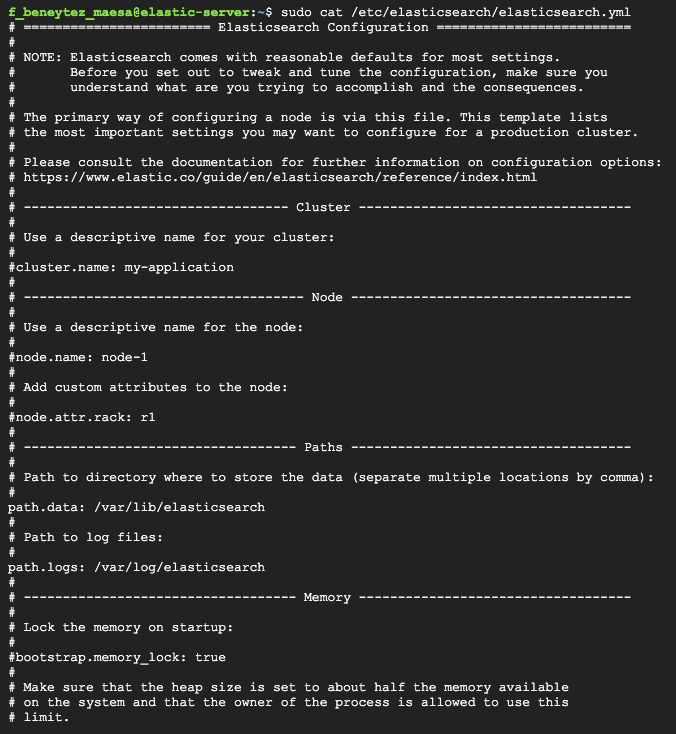

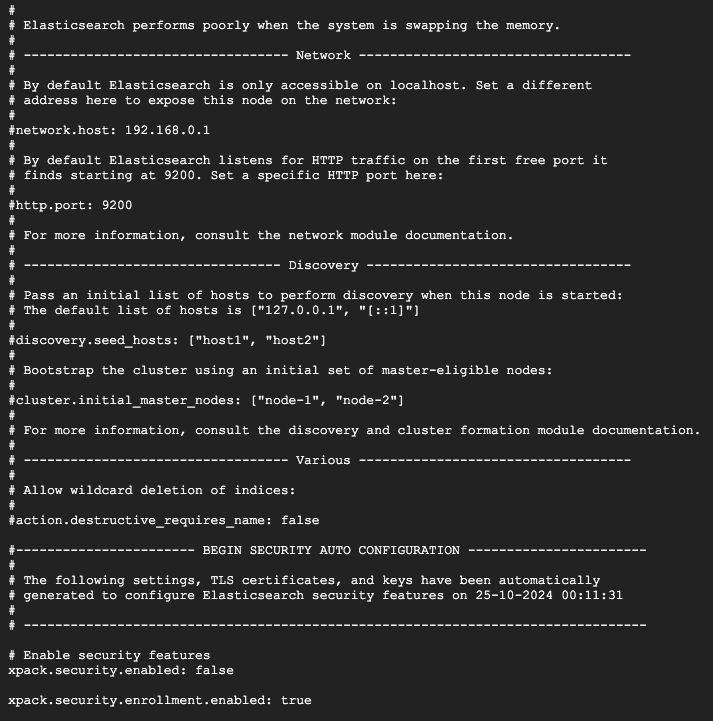

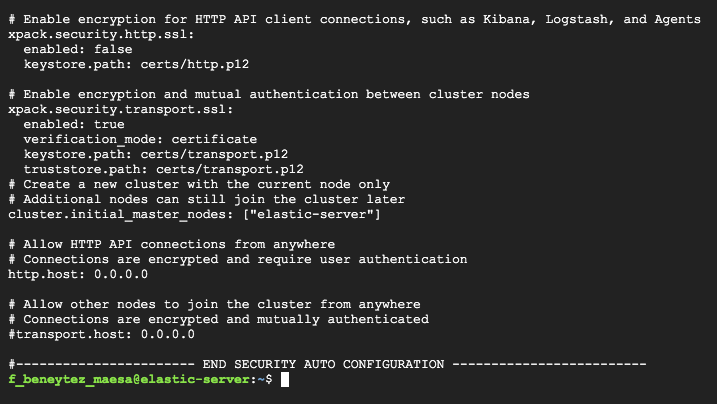

1. La configurción de Elastic:
    - xpack.security.enabled: false
    - xpack.security.http.ssl: enable: false

  Con esto conseguimos no tener problemas con los certificados ssl al conectarnos desde las diferentes máquinas.

2. También se deja configurado Kibana (para el punto 5)

3. Generación de reglas firewall para permitir las conexciones a puerto Kibana (5601) y a puerto ElasticSearch (9200) desde local y el clúster Hadoop.

4. Se comprueba la conexión entre clúster hadoop y elastic-server.

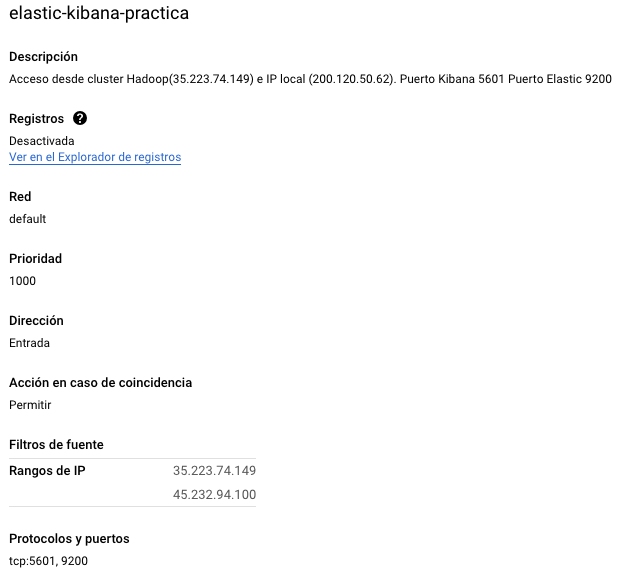

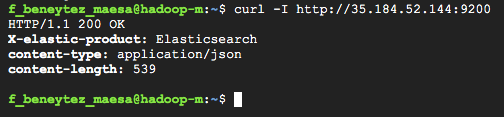

# PARTE 3 - Configuración en Cluster Hadoop de Conexión con ES

Una vez que ya hemos creado y configurado el server Elasticsearch y tenemos los ficheros en el master del cluster Dataproc, ya podemos **cargar los jars en la configuración de HIVE**. Para ello, debemos modificar el hive-site.xml.

```
sudo sed -i '$d' /etc/hive/conf.dist/hive-site.xml

sudo sed -i '$a \  <property>\n    <name>es.nodes</name>\n    <value>AQUÍ LA IP DE ELASTIC</value>\n  </property>\n' /etc/hive/conf.dist/hive-site.xml

sudo sed -i '$a \  <property>\n    <name>es.port</name>\n    <value>9200</value>\n  </property>\n' /etc/hive/conf.dist/hive-site.xml

sudo sed -i '$a \  <property>\n    <name>es.nodes.wan.only</name>\n    <value>true</value>\n  </property>\n' /etc/hive/conf.dist/hive-site.xml

sudo sed -i '$a \  <property>\n    <name>hive.aux.jars.path</name>\n   <value>/usr/lib/hive/lib/elasticsearch-hadoop-8.14.1.jar,/usr/lib/hive/lib/commons-httpclient-3.1.jar</value>\n  </property>\n</configuration>' /etc/hive/conf.dist/hive-site.xml

sudo cp elasticsearch-hadoop-8.14.1.jar /usr/lib/hive/lib/
sudo cp commons-httpclient-3.1.jar /usr/lib/hive/lib/

```

**¿Qué hacen exactamente estos comandos?**

Utilizan el editor de flujo **sed** para transformar el fichero hive-site.xml, con la opción **-i**, que modifica el archivo "in-place".

En el primer comando, '$d' representa el final del archivo. Elimina la última línea.

En el segundo comando, '$a...' indica eañadir una linea al final del archivo.
La linea que añadimos, es el cambio en la configuración, diciéndole los jars que tiene que utilizar ahora.

/etc/hive/conf.dist/hive-site.xml es la ruta donde se encuentra el archivo de configuración (esto puede variar).

El último comando, colocará los jar de elasticsearch y kibana en la ruta correcta.


Tras esto, debemos **reiniciar hive** para que se apliquen los cambios.

```
sudo service hive-server2 restart

```

##**ENTREGABLE PARTE 3**: Captura de pantalla del proceso de configuración en Cluster Hadoop de Conexión con ES completo.

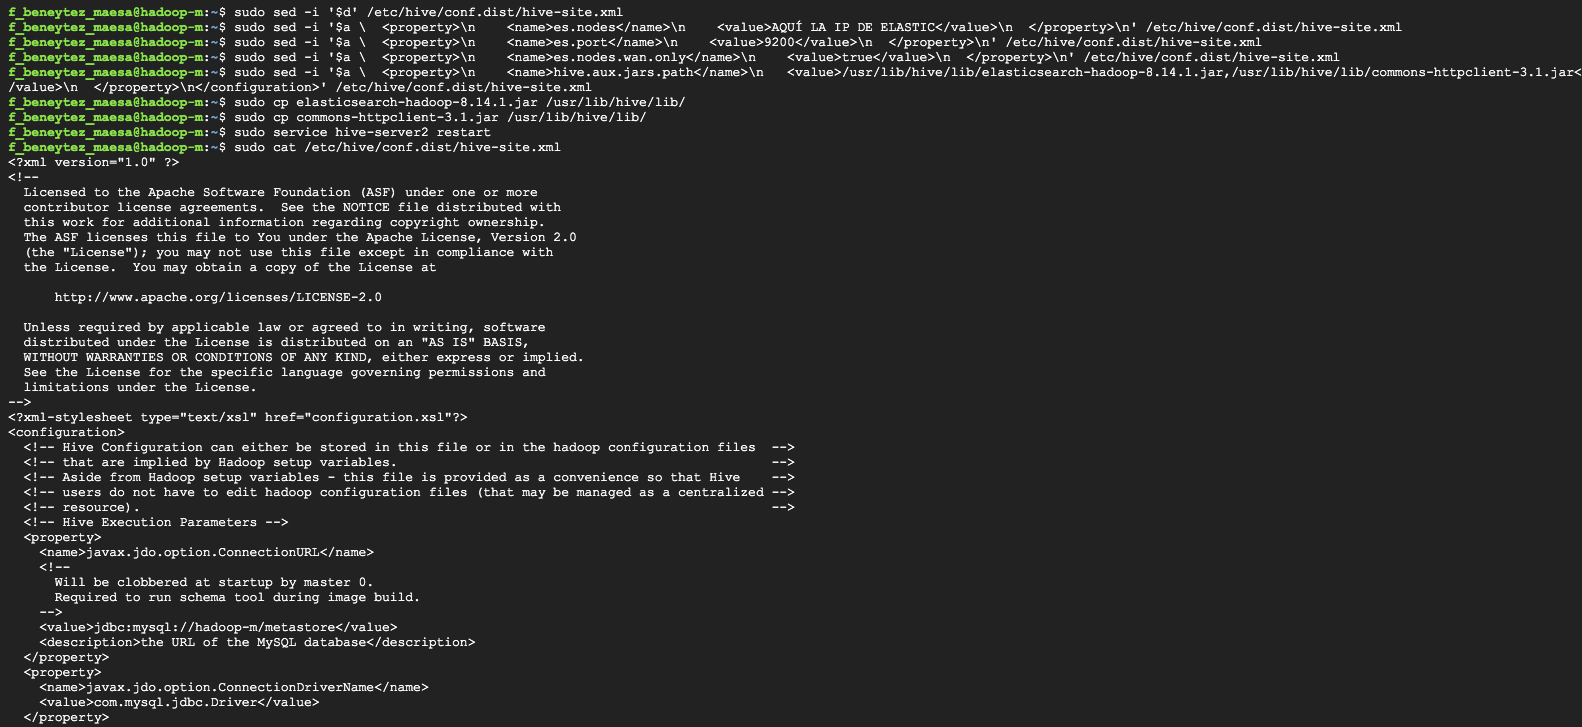

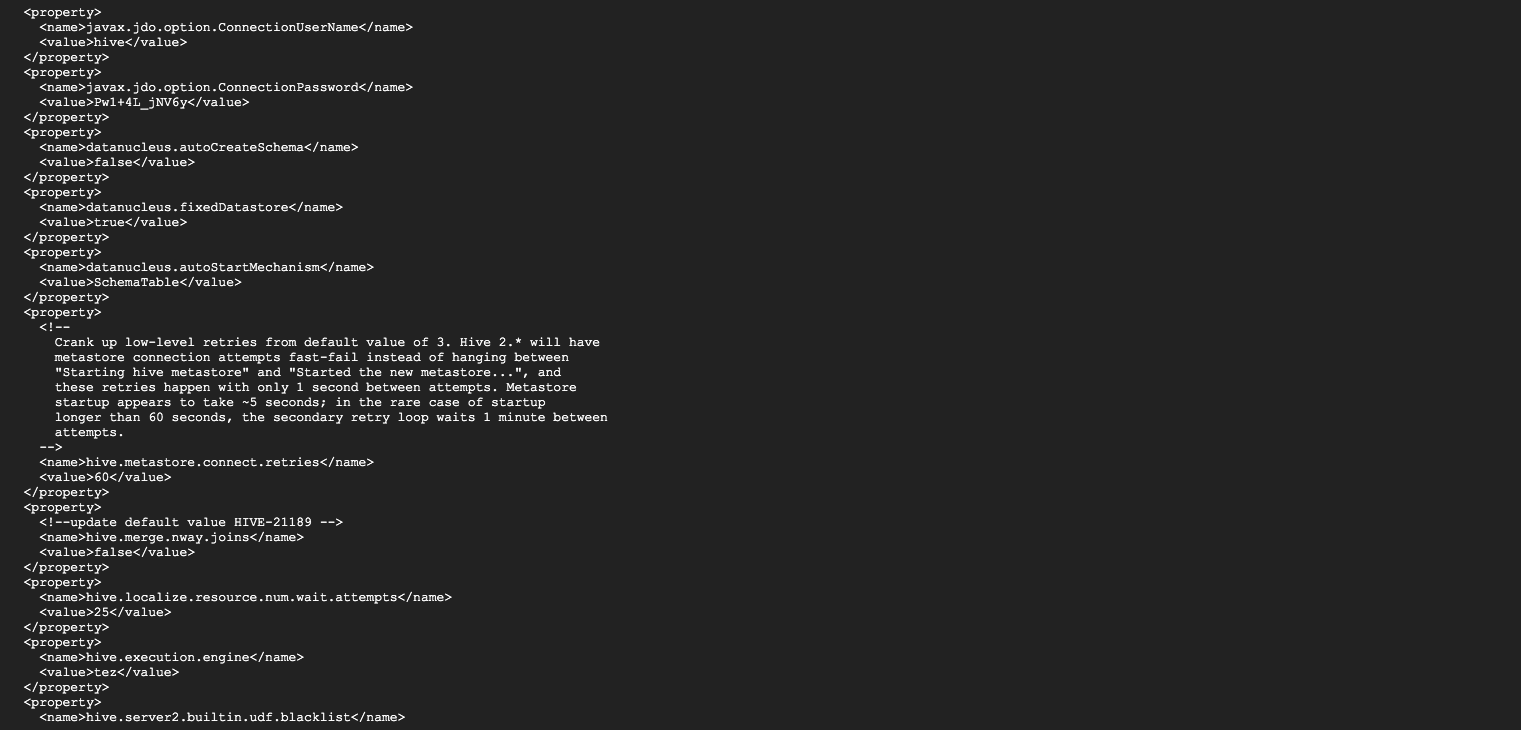

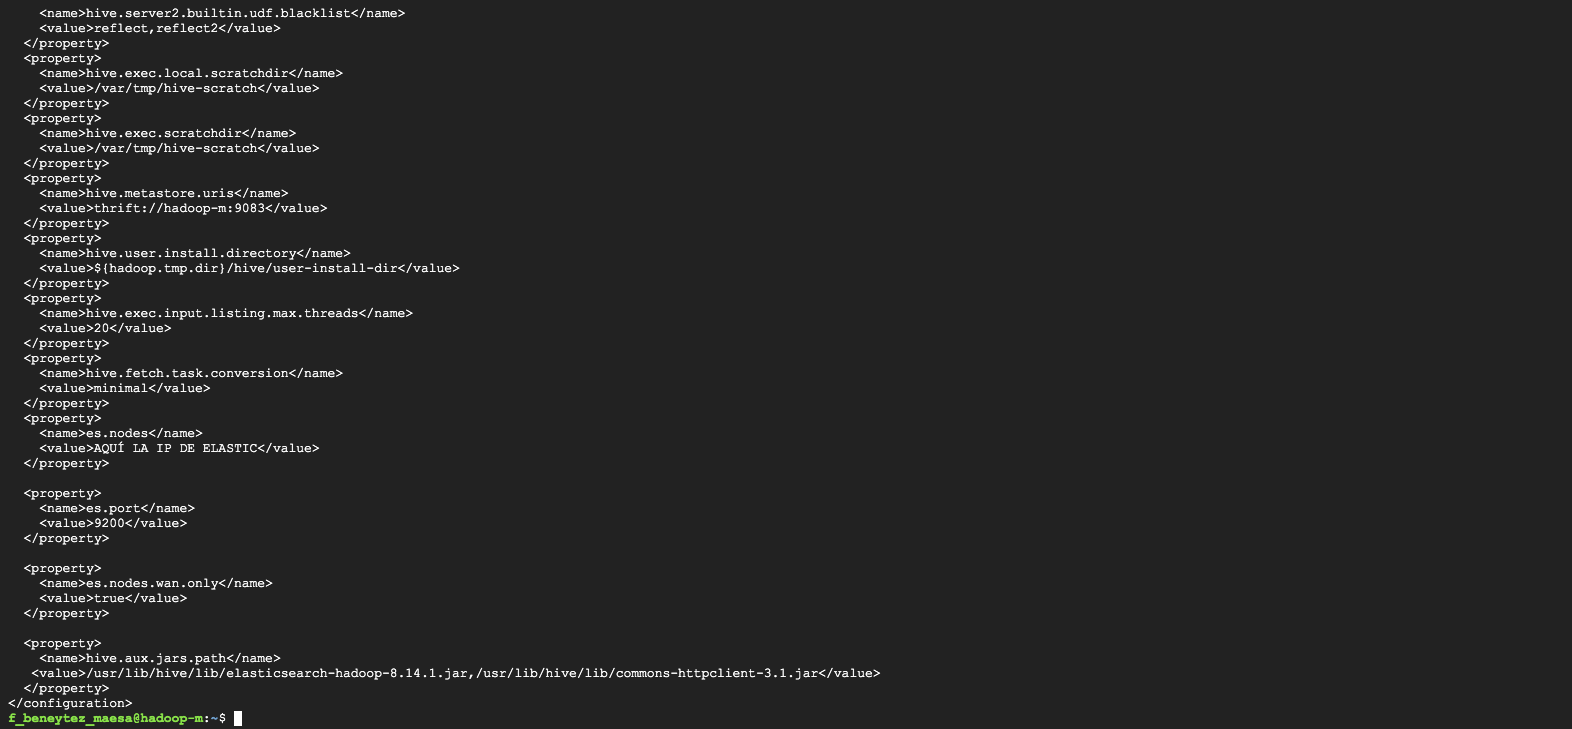

# PARTE 4 - A conectar datos!

No olvidemos tener los Firewall correctamente configurados (debe estar hecho desde la parte 2)

Ahora, desde nuestro **server Elasticsearch**, vamos a crear  un índice sobre el que despúés trabajaremos en el cluster Hadoop:


```
curl -X POST "localhost:9200/alumnos/_doc/6" -H 'Content-Type: application/json' -d'
{
  "title": "New Document",
  "content": "This is a new document for the master class",
  "tag": ["general", "testing"]
}
'
```

Finalmente, en **nuestro cluster Hadoop**, vamos a agregar documentos al index alumnos recién creado:


```
curl -X POST "35.184.52.144:9200/_bulk" -H 'Content-Type: application/json' -d'
{ "index": { "_index": "alumnos", "_id": "3" } }
{ "id": 3, "name": "Carlos", "last_name": "González" }
{ "index": { "_index": "alumnos", "_id": "4" } }
{ "id": 4, "name": "María", "last_name": "López" }
{ "index": { "_index": "alumnos", "_id": "5" } }
{ "id": 5, "name": "Luis", "last_name": "Martínez" }
{ "index": { "_index": "alumnos", "_id": "7" } }
{ "id": 7, "name": "Sofía", "last_name": "Ramírez" }
{ "index": { "_index": "alumnos", "_id": "8" } }
{ "id": 8, "name": "Pedro", "last_name": "Hernández" }
'
```
Podemos comprobar que efectivamente se ha creado con una sencilla consulta:


Hagamos una consulta para ahora para ver los datos insertados:

```
curl -X GET "http://35.184.52.144:9200/alumnos/_search?pretty"
```

##**ENTREGABLE PARTE 4**: Captura de pantalla de la consola del cluster Hadoop con el resultado la consulta.

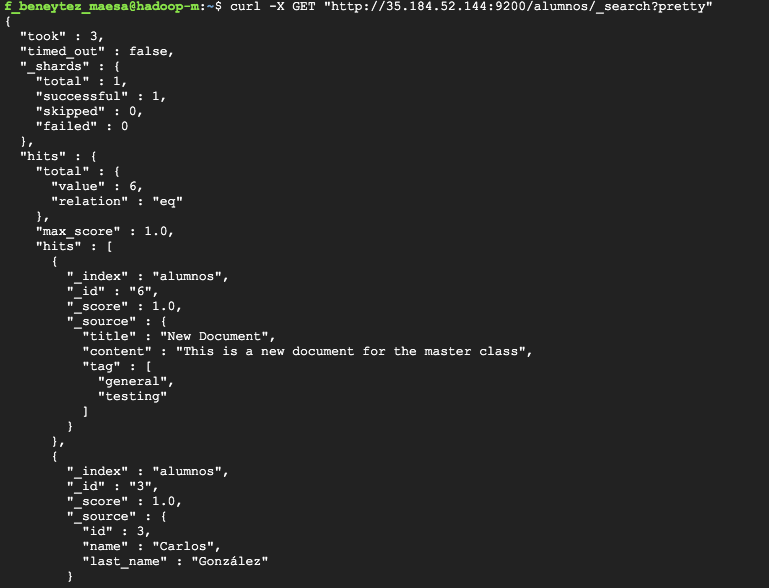

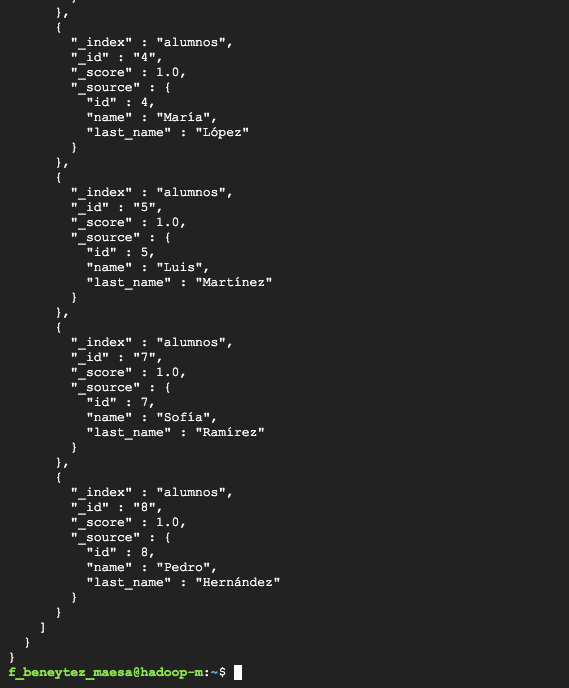

1. Antes de hacer la consulta, se comprobó que la inserción de datos fuera correcta al comprobar la ausencia de errores.
    - "errors:false......", "failed":0...."

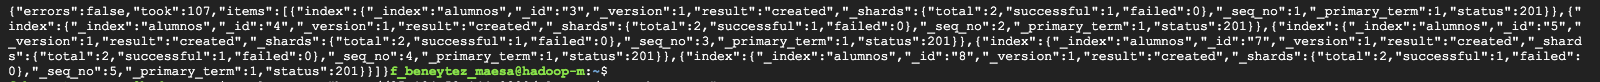

#PARTE 5 - Opcional. KIBANA!

Para esta parte, la idea es que explores Kibana y hagas un sencillo Dashboard, con el objetivo de que conozcas la herramienta y veas sus posibilidades.

Para ello:

En nuestro navegador, visitemos: **http://IP_ELASTIC_SERVER:5601**

En el menú izquierdo, en **Analitycs**, hacemos click en **Dashboards**.

Hacemos click en **Create Dataview**, donde debemos seleccionar el index alumnos (hay que escribirlo). Y tras ello, hacemos click sobre **Create Dashboard** y **Create Visualization**

Una vez estemos en la pantalla del dashboard, podremos elegir una gran variedad de tipos de gráficos, visualizaciones etc. Solo queda explorar y probar algunas de las diferentes opciones!

##**ENTREGABLE 5**: Opcional. Captura de pantalla de la consola de Kibana con alguna visualización sencilla.



1. Cargo al notebook el archivo .jsonld desde el bucket de Google Storage.

In [1]:
!pip install google-cloud-storage==2.8.0

In [2]:
from google.cloud import storage
from google.colab import auth

auth.authenticate_user()

storage_client = storage.Client()

bucket = storage_client.bucket('elastic-hadoop-1')
blob = bucket.blob('ea0042931-indicadores-trimestrales-del-transporte-ferroviario-de-viajeros.json')
blob.download_to_filename('/content/ea0042931-indicadores-trimestrales-del-transporte-ferroviario-de-viajeros.json')

2. Ya está el archivo en Collab. Se accede a el y se procede a la transformación del archivo .jsonld a .json elasticsearch

In [ ]:
!pip install pyld==2.0.3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.2/70.2 kB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyld: filename=PyLD-2.0.3-py3-none-any.whl size=70847 sha256=3e0894d2d13bee962b5efc6b53f0bce69a01c7645f5f490986b935874f849f50
  Stored in directory: /root/.cache/pip/wheels/83/f1/37/b168e54c94545d0d41ddbcca7008cbd6f51fc967be7414309b
Successfully built pyld


In [14]:
import json

def convert_to_elasticsearch_json(input_json):
    """Convierte un JSON de entrada al formato de Elasticsearch.

    Args:
        input_json: Una lista de diccionarios en formato JSON.

    Returns:
        Una lista de diccionarios en formato JSON de Elasticsearch.
    """
    output_json = []
    for item in input_json:
        # Define el índice y el tipo de documento.
        index = "trenes"  # Reemplaza por tu nombre de índice.
        doc_type = "_doc"  # Reemplaza por tu tipo de documento.

        # Crea un nuevo diccionario en el formato de Elasticsearch.
        es_json = {
            "_index": index,
            "_source": item,
        }

        # Agrega el diccionario al JSON de salida.
        output_json.append(es_json)

    return output_json

with open('/content/ea0042931-indicadores-trimestrales-del-transporte-ferroviario-de-viajeros.json', 'r') as f:
  input_json = json.load(f)

output_json = convert_to_elasticsearch_json(input_json)

print(json.dumps(output_json, indent=2))

with open('trenes.json', 'w') as outfile:
     json.dump(output_json, outfile, indent=2)

[
  {
    "_index": "trenes",
    "_source": {
      "trimestre": "2016T1",
      "tipo_de_producto": "Cercan\u00edas",
      "corredor": "Total",
      "empresa": "Total",
      "tipo_de_servicio": "OSP",
      "ingresos_por_venta_de_billetes": null,
      "plazas_ofertadas": null,
      "plazas_km_ofertadas": 5836879371,
      "tren_km": 16638744,
      "viajeros": 100892888,
      "viajeros_km": 1924136032
    }
  },
  {
    "_index": "trenes",
    "_source": {
      "trimestre": "2016T1",
      "tipo_de_producto": "LD AV",
      "corredor": "Madrid-Alicante",
      "empresa": "Renfe Viajeros S.A.U.",
      "tipo_de_servicio": "Comercial",
      "ingresos_por_venta_de_billetes": null,
      "plazas_ofertadas": null,
      "plazas_km_ofertadas": 185703252,
      "tren_km": 587646,
      "viajeros": 355281,
      "viajeros_km": 135603638
    }
  },
  {
    "_index": "trenes",
    "_source": {
      "trimestre": "2016T1",
      "tipo_de_producto": "LD AV",
      "corredor": "Madrid-Bar

3. Una vez expandido el archivo .json se puede indexar en el server-elastic (máquina virtual creada con elasticsearch y kibana). Para esto lo primero es conectar el notebook con elastic-server, para lo cual se debe generar la regla de firewall concediendo acceso a la IP del notebook y abriendo el puerto 9200

In [6]:
#Obtener IP de notebook para cocederle acceso a elastic-server
!curl ipecho.net/plain

34.46.91.119

In [7]:
!pip install elasticsearch==8.6.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 385.4/385.4 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 4.9 MB/s eta 0:00:00


In [15]:
from elasticsearch import Elasticsearch, helpers

es = Elasticsearch(['http://34.46.189.103:9200'])

with open('/content/trenes.json') as f:
    data = json.load(f)

helpers.bulk(es, data)



(407, [])

Hay que recordar que al iniciar elastic-server, si este estaba apagado, hay que iniciar los servicios de elastic y kibana

```bash
sudo service elasticsearch restart
sudo service kibana restart
````


4. Ya esta lista la indexación. Ahora para poder realizar el dashboard en Kibana hay que acceder desde el navegardor a http://34.46.189.103:5601/

5. Se crean visualizaciones en Kibana y se genera dashboar

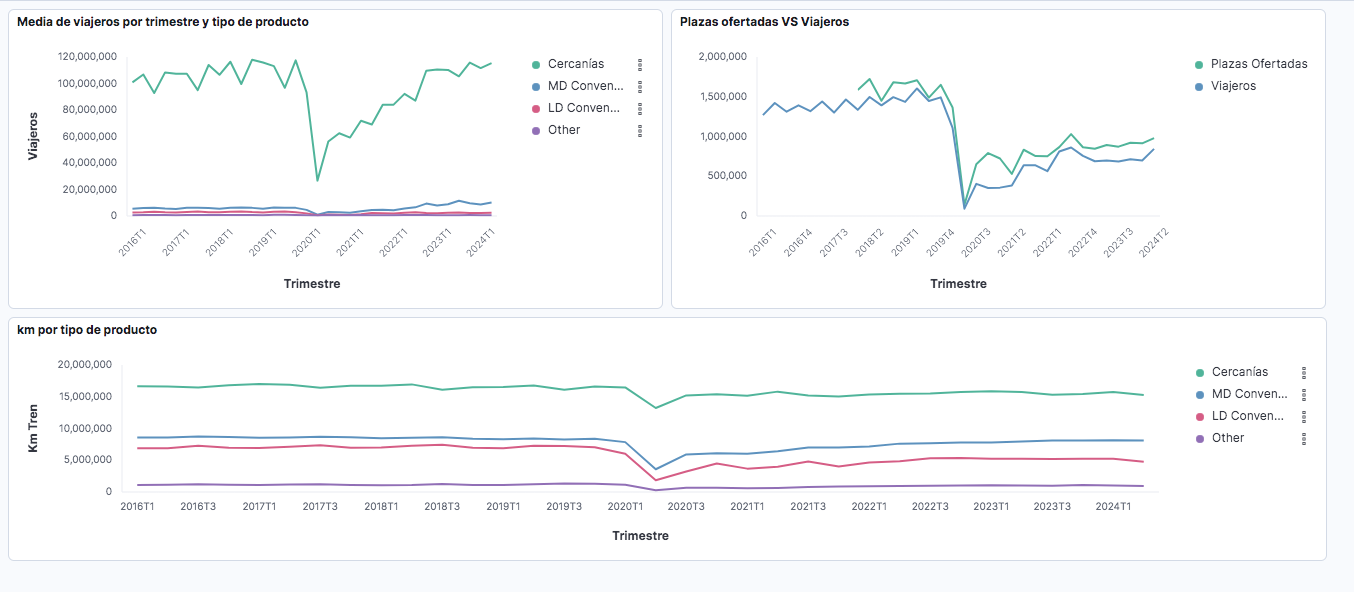

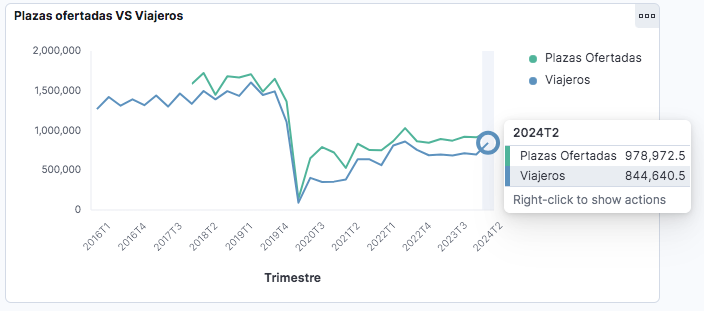

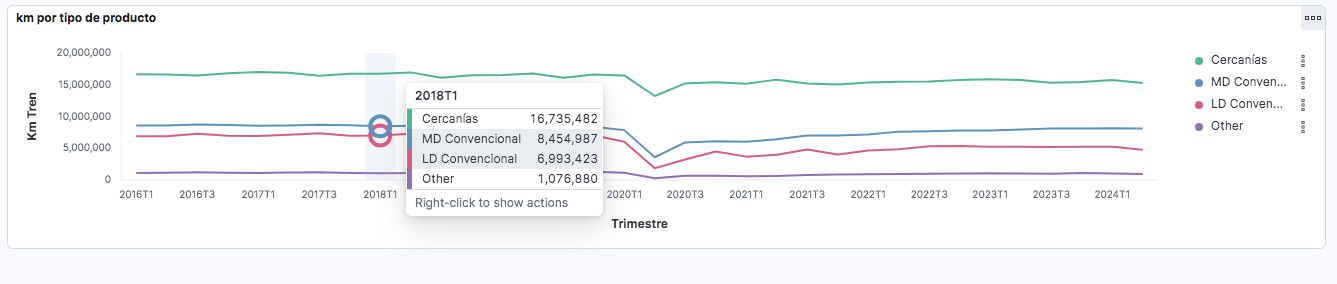

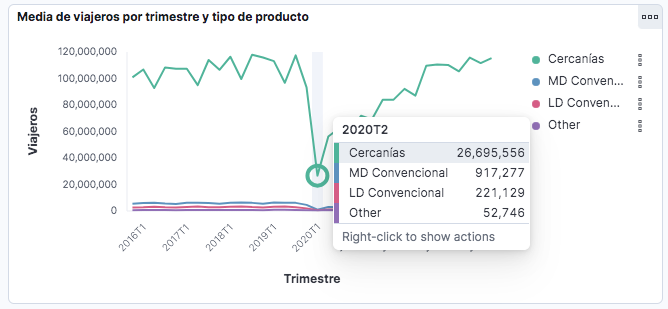

Los datos han sido extraidos de una fuente oficial del Reino de España. https://datos.gob.es/en/catalogo?theme_id=transporte&res_format_label=JSON

Se adjuntan archivos .json con y sin índice